Temporal：
* Joint Angle Velocity
* Velocity Ratio
* Acceleration
* Movement Curvature
* Multi-Scale Window Statistics
* Joint Distance Change
* Movement Magnitude

Sequential：
* Pose Change Rate
* Movement Direction Consistency
* Joint Coordination Index
* Movement Continuity Metrics


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
DATA_FOLDER = "/content/drive/MyDrive/Random/Hiroshima/ABC2025/Test"

# 训练 ID
USER_IDS = ["T1N01", "T1F01", "T1S01", "T1S02"]
# 测试 ID
TEST_IDS = ["T1N02", "T1F02"]

FS = 33  # Sampling rate

# 动作标签 -> ID
action_mapping = {
    "Explanation to patient": 0,
    "Confirm necessary items": 1,
    "Disinfect hands": 2,
    "Wearing gloves": 3,
    "Prepare the nutrition solution": 4,
    "Check the gastrostomy site": 5,
    "Open the gastrostomy cap": 6,
    "Inject lukewarm water": 7,
    "Connect the nutrition tube": 8,
    "Adjust the infusion rate": 9,
    "Removal of gloves": 10,
    "Prepare lukewarm water": 11,
    "Close the clamp": 12,
    "Disconnect the nutrition tube": 13,
    "Close the gastrostomy cap": 14,
    "Clean up used items": 15,
    "Others": 16
}

In [4]:
def load_data(user_ids, data_folder=DATA_FOLDER):
    all_kp_data = []
    all_ann_data= []
    for user_id in user_ids:
        keypoint_csv = f"{data_folder}/Body_KeyPoint_CSV/Front_{user_id}.csv"
        ann_csv      = f"{data_folder}/Annotation_CSV/Front_{user_id}.csv"
        kp_df_raw  = pd.read_csv(keypoint_csv)
        ann_df_raw = pd.read_csv(ann_csv)

        kp_df= kp_df_raw.loc[:, ~kp_df_raw.columns.str.contains('^Unnamed')]
        ann_df= ann_df_raw.loc[:, ~ann_df_raw.columns.str.contains('^Unnamed')]

        # 删除部分关节点 (膝盖/脚踝等)
        kp_df= kp_df.loc[:, ~kp_df.columns.str.contains('Frame|conf|left_knee|right_knee|left_ankle|right_ankle', regex=True)]

        all_kp_data.append(kp_df)
        all_ann_data.append(ann_df)
    return all_kp_data, all_ann_data

print("Loading training data...")
all_kp_data, all_ann_data= load_data(USER_IDS)
print("Loading testing data...")
test_all_kp_data, test_all_ann_data= load_data(TEST_IDS)
print("Data loaded successfully!")

Loading training data...
Loading testing data...
Data loaded successfully!


In [5]:
SMOOTH_LEN= 3

def smooth_kp(kp_col, fs=FS, smooth_len=SMOOTH_LEN):
    zero_idx= np.flatnonzero(kp_col==0)
    split_idx= np.split(zero_idx, np.flatnonzero(np.diff(zero_idx)>1)+1)
    for each_split_idx in split_idx:
        if (len(each_split_idx)==0
            or each_split_idx[0]==0
            or each_split_idx[-1]==(len(kp_col)-1)
            or len(each_split_idx)> smooth_len*fs):
            continue
        xp= [each_split_idx[0]-1, each_split_idx[-1]+1]
        fp= kp_col[xp]
        interp_kp= np.interp(each_split_idx, xp, fp)
        kp_col[each_split_idx]= interp_kp
    return kp_col

def smooth_all_data(all_kp_data):
    for kp_df in all_kp_data:
        for col in kp_df.columns:
            kp_df[col]= smooth_kp(np.array(kp_df[col]))
    return all_kp_data

print("Smoothing training data...")
all_kp_data= smooth_all_data(all_kp_data)
print("Smoothing testing data...")
test_all_kp_data= smooth_all_data(test_all_kp_data)
print("All data smoothed!")

Smoothing training data...
Smoothing testing data...
All data smoothed!


In [6]:
for ann_df in all_ann_data:
    ann_df["activityID"]= ann_df["annotation"].map(action_mapping)
for ann_df in test_all_ann_data:
    ann_df["activityID"]= ann_df["annotation"].map(action_mapping)
print("Mapped activity labels to activity IDs.")

Mapped activity labels to activity IDs.


In [7]:
WINDOW_SIZE=2
OVERLAP_RATE=0.5*WINDOW_SIZE

def segment(data, max_time, sub_window_size, stride_size):
    sub_windows= np.arange(sub_window_size)[None,:] + np.arange(0, max_time, stride_size)[:, None]
    row, _= np.where(sub_windows>=max_time)
    uniq_row= len(np.unique(row))
    if uniq_row>0 and row[0]>0:
        sub_windows= sub_windows[:-uniq_row,:]
    return data[sub_windows]

In [18]:
import numpy as np
from scipy.spatial.distance import euclidean
from scipy.stats import entropy
from scipy.signal import savgol_filter

# Preserved original functions
def cal_angle(a, b, c):
    """Calculate angle between three points, with b as center"""
    ba = a - b
    bc = c - b
    nb = np.linalg.norm(ba)
    nc = np.linalg.norm(bc)
    if nb < 1e-12 or nc < 1e-12:
        return 0
    cos_val = np.dot(ba, bc)/(nb*nc)
    cos_val = np.clip(cos_val, -1.0, 1.0)
    return np.arccos(cos_val)

def extract_joint_angles(kp_data, steps=2):
    """Calculate 6 joint angles => (n_frames, 6)"""
    joint_pairs = [
        ((7, 5, 11), "left_elbow_shoulder_hip"),
        ((8, 6, 12), "right_elbow_shoulder_hip"),
        ((9, 7, 5), "left_wrist_elbow_shoulder"),
        ((10, 8, 6), "right_wrist_elbow_shoulder"),
        ((8, 6, 5), "right_elbow_shoulder"),
        ((6, 5, 7), "left_elbow_shoulder")
    ]

    angles = []
    for (j1, j2, j3), _ in joint_pairs:
        angle = np.asarray([
            cal_angle(
                kp_data[i, j1*steps:(j1*steps+2)],
                kp_data[i, j2*steps:(j2*steps+2)],
                kp_data[i, j3*steps:(j3*steps+2)]
            ) for i in range(len(kp_data))
        ], dtype=np.float32)
        angles.append(np.nan_to_num(angle))

    return np.column_stack(angles)

def extract_velocity(kp_data):
    """Calculate velocity from keypoint data"""
    return np.diff(kp_data, axis=0)

def extract_feature(data, fs):
    """Extract statistical features"""
    stats = [
        np.mean(data, axis=0),
        np.std(data, axis=0),
        np.max(data, axis=0),
        np.min(data, axis=0),
        np.var(data, axis=0),
        np.median(data, axis=0),
        np.sum(data, axis=0)
    ]
    feats = np.array(stats).T.flatten()
    return np.nan_to_num(feats)

# New Temporal Features
def joint_angle_velocity(joint_angles):
    """Calculate joint angle velocities"""
    return np.diff(joint_angles, axis=0)

def velocity_ratio(velocities):
    """Calculate ratio between consecutive velocities"""
    v_norm = np.linalg.norm(velocities, axis=1)
    return v_norm[1:] / (v_norm[:-1] + 1e-6)

def extract_acceleration(velocities):
    """Calculate acceleration from velocities"""
    return np.diff(velocities, axis=0)

def movement_curvature(kp_data):
    """Calculate movement curvature using three consecutive points"""
    velocity = extract_velocity(kp_data)
    acceleration = extract_acceleration(velocity)
    v_norm = np.linalg.norm(velocity[1:], axis=1)
    a_norm = np.linalg.norm(acceleration, axis=1)
    curvature = a_norm / (v_norm**2 + 1e-6)
    return curvature

def multi_scale_window_stats(data, window_sizes=[1, 2, 3]):
    """Calculate statistics over multiple window sizes"""
    stats = []
    for w_size in window_sizes:
        if len(data) < w_size:
            continue
        rolling_mean = np.array([np.mean(data[i:i+w_size], axis=0)
                               for i in range(len(data)-w_size+1)])
        rolling_std = np.array([np.std(data[i:i+w_size], axis=0)
                              for i in range(len(data)-w_size+1)])
        stats.extend([rolling_mean, rolling_std])
    return np.concatenate(stats) if stats else np.array([])

def joint_distance_change(kp_data):
    """Calculate changes in joint distances over time"""
    dist_matrix = np.zeros((len(kp_data), kp_data.shape[1]//2, kp_data.shape[1]//2))
    for t in range(len(kp_data)):
        for i in range(kp_data.shape[1]//2):
            for j in range(i+1, kp_data.shape[1]//2):
                dist_matrix[t,i,j] = euclidean(
                    kp_data[t, 2*i:2*i+2],
                    kp_data[t, 2*j:2*j+2]
                )
    return np.diff(dist_matrix, axis=0)

def movement_magnitude(velocities):
    """Calculate overall movement magnitude"""
    return np.linalg.norm(velocities, axis=1)

# New Sequential Features
def pose_change_rate(joint_angles, threshold=0.1):
    """Calculate rate of significant pose changes"""
    angle_diff = np.diff(joint_angles, axis=0)
    significant_changes = np.abs(angle_diff) > threshold
    return np.mean(significant_changes, axis=1)

def movement_direction_consistency(velocities, window_size=2):
    """Calculate consistency of movement direction"""
    if len(velocities) < window_size:
        return np.array([])

    v_normalized = velocities / (np.linalg.norm(velocities, axis=1, keepdims=True) + 1e-6)
    consistency = []

    for i in range(len(velocities)-window_size+1):
        window = v_normalized[i:i+window_size]
        cos_sim = np.dot(window[:-1], window[1:].T)
        consistency.append(np.mean(cos_sim))

    return np.array(consistency)

def joint_coordination_index(joint_angles):
    """Calculate coordination between joint movements"""
    angle_vel = np.diff(joint_angles, axis=0)
    correlation_matrix = np.corrcoef(angle_vel.T)
    return np.mean(np.abs(correlation_matrix))

def movement_continuity_metrics(velocities, window_size=2):
    """Calculate metrics for movement continuity"""
    if len(velocities) < window_size:
        return np.array([])

    # Smoothness using velocity profile
    jerk = np.diff(velocities, axis=0, n=2)
    smoothness = -np.log(np.mean(np.square(jerk)) + 1e-6)

    # Rhythmicity using autocorrelation
    v_magnitude = np.linalg.norm(velocities, axis=1)
    autocorr = np.correlate(v_magnitude, v_magnitude, mode='full')
    autocorr = autocorr[len(autocorr)//2:]

    return np.array([smoothness, np.max(autocorr[1:])])

def extract_all_features(kp_data, fs=33):
    """Extract all features from keypoint data"""
    # Basic features
    joint_angles = extract_joint_angles(kp_data)
    velocities = extract_velocity(kp_data)

    # Temporal features
    angle_vel = joint_angle_velocity(joint_angles)
    vel_ratio = velocity_ratio(velocities)
    acceleration = extract_acceleration(velocities)
    curvature = movement_curvature(kp_data)
    multi_scale_stats = multi_scale_window_stats(kp_data)
    dist_change = joint_distance_change(kp_data)
    move_magnitude = movement_magnitude(velocities)

    # Sequential features
    pose_changes = pose_change_rate(joint_angles)
    direction_consistency = movement_direction_consistency(velocities)
    coord_index = joint_coordination_index(joint_angles)
    continuity = movement_continuity_metrics(velocities)

    # Combine all features
    feature_sets = [
        extract_feature(joint_angles, fs),
        extract_feature(velocities, fs),
        extract_feature(angle_vel, fs),
        extract_feature(vel_ratio.reshape(-1,1), fs),
        extract_feature(acceleration, fs),
        extract_feature(curvature.reshape(-1,1), fs),
        extract_feature(multi_scale_stats.reshape(-1,1), fs),
        extract_feature(dist_change.reshape(-1, dist_change.shape[1]*dist_change.shape[2]), fs),
        extract_feature(move_magnitude.reshape(-1,1), fs),
        extract_feature(pose_changes.reshape(-1,1), fs),
        extract_feature(direction_consistency.reshape(-1,1), fs),
        np.array([coord_index]),
        extract_feature(continuity.reshape(-1,1), fs)
    ]

    return np.concatenate([f for f in feature_sets if f.size > 0])

In [29]:
def pad_or_truncate(vec, target_len=182):
    """Pad or truncate vector to target length"""
    vec = vec.ravel()
    if len(vec) == target_len:
        return vec
    elif len(vec) < target_len:
        out = np.zeros(target_len, dtype=vec.dtype)
        out[:len(vec)] = vec
        return out
    else:
        return vec[:target_len]

def segment(data, max_time, sub_window_size, stride_size):
    """Segment data into windows"""
    sub_windows = np.arange(sub_window_size)[None,:] + np.arange(0, max_time, stride_size)[:, None]
    row, _ = np.where(sub_windows >= max_time)
    uniq_row = len(np.unique(row))
    if uniq_row > 0 and row[0] > 0:
        sub_windows = sub_windows[:-uniq_row,:]
    return data[sub_windows]

In [30]:
def extract_all_features(kp_df, ann_df, desired_len=182, fs=33):
    # Fixed window parameters to match original sample numbers
    window_size = 2  # 2 seconds
    overlap_rate = window_size * 0.5  # This matches the original calculation

    all_features = []
    all_labels = []

    for idx in range(len(ann_df)):
        start_idx = int(ann_df['start_time'].iloc[idx] * fs)
        stop_idx = int(ann_df['stop_time'].iloc[idx] * fs)
        seg = kp_df.loc[start_idx:stop_idx]
        seg_label = ann_df["activityID"].iloc[idx]

        if len(seg) < window_size * fs:
            continue

        # 1) Calculate intermediate data
        segment_data = np.array(seg)
        joint_angles = extract_joint_angles(segment_data, steps=2)
        velocity = extract_velocity(segment_data)

        # 2) Calculate temporal features
        angle_vel = joint_angle_velocity(joint_angles)
        vel_ratio = velocity_ratio(velocity)
        acceleration = extract_acceleration(velocity)
        curvature = movement_curvature(segment_data)
        move_magnitude = movement_magnitude(velocity)

        # 3) Calculate sequential features
        pose_changes = pose_change_rate(joint_angles)
        direction_consistency = movement_direction_consistency(velocity)
        coord_index = joint_coordination_index(joint_angles)
        continuity_metrics = movement_continuity_metrics(velocity)

        # 4) Segment using sliding windows
        ws_seg = segment(segment_data, max_time=len(seg),
                        sub_window_size=window_size*fs,
                        stride_size=int((window_size-overlap_rate)*fs))

        joint_angles_seg = segment(joint_angles, max_time=len(seg),
                                 sub_window_size=window_size*fs,
                                 stride_size=int((window_size-overlap_rate)*fs))

        # Initialize lists for windowed features
        velocity_list = []
        accel_list = []
        angle_vel_list = []

        # Calculate features for each window
        for sub_seg in ws_seg:
            velocity_list.append(extract_velocity(sub_seg))
            accel_list.append(extract_acceleration(extract_velocity(sub_seg)))
            angle_vel_list.append(joint_angle_velocity(extract_joint_angles(sub_seg, steps=2)))

        num_segments = len(ws_seg)

        # 5) Extract features for each segment and pad
        for j in range(num_segments):
            # a) Base skeleton stats
            skeleton_stats = extract_feature(ws_seg[j], fs)
            skeleton_stats = pad_or_truncate(skeleton_stats, desired_len)

            # b) Joint angle stats
            angle_stats = extract_feature(joint_angles_seg[j], fs)
            angle_stats = pad_or_truncate(angle_stats, desired_len)

            # c) Velocity stats
            if len(velocity_list[j]) > 0:
                vel_stats = extract_feature(velocity_list[j], fs)
            else:
                vel_stats = np.zeros(1, dtype=np.float32)
            vel_stats = pad_or_truncate(vel_stats, desired_len)

            # d) Acceleration stats
            if len(accel_list[j]) > 0:
                acc_stats = extract_feature(accel_list[j], fs)
            else:
                acc_stats = np.zeros(1, dtype=np.float32)
            acc_stats = pad_or_truncate(acc_stats, desired_len)

            # e) Joint angle velocity stats
            if len(angle_vel_list[j]) > 0:
                angle_vel_stats = extract_feature(angle_vel_list[j], fs)
            else:
                angle_vel_stats = np.zeros(1, dtype=np.float32)
            angle_vel_stats = pad_or_truncate(angle_vel_stats, desired_len)

            # f) Curvature stats
            curve_stats = extract_feature(curvature.reshape(-1, 1), fs)
            curve_stats = pad_or_truncate(curve_stats, desired_len)

            # g) Movement magnitude stats
            mag_stats = extract_feature(move_magnitude.reshape(-1, 1), fs)
            mag_stats = pad_or_truncate(mag_stats, desired_len)

            # h) Pose change rate stats
            pcr_stats = extract_feature(pose_changes.reshape(-1, 1), fs)
            pcr_stats = pad_or_truncate(pcr_stats, desired_len)

            # i) Direction consistency stats
            dir_stats = extract_feature(direction_consistency.reshape(-1, 1), fs)
            dir_stats = pad_or_truncate(dir_stats, desired_len)

            # j) Coordination index (scalar)
            coord_stats = np.array([coord_index], dtype=np.float32)
            coord_stats = pad_or_truncate(coord_stats, desired_len)

            # k) Continuity metrics
            cont_stats = extract_feature(continuity_metrics.reshape(-1, 1), fs)
            cont_stats = pad_or_truncate(cont_stats, desired_len)

            # Combine all features
            combined = np.concatenate([
                skeleton_stats, angle_stats, vel_stats, acc_stats,
                angle_vel_stats, curve_stats, mag_stats, pcr_stats,
                dir_stats, coord_stats, cont_stats
            ])

            all_features.append(combined)
            all_labels.append(seg_label)

    if len(all_features) == 0:
        return np.array([]), np.array([])

    all_features = np.array(all_features, dtype=np.float32)
    all_labels = np.array(all_labels, dtype=np.int32)

    return all_features, all_labels

# Process training data
print("Extracting features and labels for training data...")
train_all_features, train_all_labels = [], []
for kp_df, ann_df in zip(all_kp_data, all_ann_data):
    feats, labs = extract_all_features(kp_df, ann_df)
    if len(feats) > 0:
        train_all_features.append(feats)
        train_all_labels.append(labs)

if len(train_all_features) > 0:
    train_all_features = np.vstack(train_all_features)
    train_all_labels = np.hstack(train_all_labels)
else:
    train_all_features = np.array([])
    train_all_labels = np.array([])

# Process testing data
print("Extracting features and labels for testing data...")
test_all_features, test_all_labels = [], []
for kp_df, ann_df in zip(test_all_kp_data, test_all_ann_data):
    feats, labs = extract_all_features(kp_df, ann_df)
    if len(feats) > 0:
        test_all_features.append(feats)
        test_all_labels.append(labs)

if len(test_all_features) > 0:
    test_all_features = np.vstack(test_all_features)
    test_all_labels = np.hstack(test_all_labels)
else:
    test_all_features = np.array([])
    test_all_labels = np.array([])

print("Feature extraction completed!")
print("Train feature shape:", train_all_features.shape)
print("Test feature shape:", test_all_features.shape)

Extracting features and labels for training data...
Extracting features and labels for testing data...
Feature extraction completed!
Train feature shape: (1069, 2002)
Test feature shape: (526, 2002)


In [31]:
print("NaN in training features:", np.isnan(train_all_features).sum())
print("NaN in testing features:", np.isnan(test_all_features).sum())
print("Inf in training features:", np.isinf(train_all_features).sum())
print("Inf in testing features:", np.isinf(test_all_features).sum())

# Replace NaN/Inf => 0
train_all_features= np.nan_to_num(train_all_features, nan=0.0, posinf=0.0, neginf=0.0)
test_all_features = np.nan_to_num(test_all_features,  nan=0.0, posinf=0.0, neginf=0.0)

NaN in training features: 0
NaN in testing features: 0
Inf in training features: 0
Inf in testing features: 0


In [32]:
!pip install imbalanced-learn --quiet
from imblearn.over_sampling import SMOTE
smote= SMOTE(k_neighbors=2, random_state=42)
X_train_resampled, y_train_resampled= smote.fit_resample(train_all_features, train_all_labels)

In [33]:
from sklearn.ensemble import RandomForestClassifier
model_rf= RandomForestClassifier(
    bootstrap=False,
    max_depth=20,
    max_features='sqrt',
    min_samples_leaf=2,
    min_samples_split=2,
    n_estimators=300,
    n_jobs=-1,
    random_state=42
)
model_rf.fit(X_train_resampled, y_train_resampled)
print("Model training completed!")

Model training completed!


Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.37      0.48        51
           1       1.00      0.66      0.79        35
           2       0.26      0.53      0.35        17
           3       0.97      0.48      0.64        63
           4       0.52      0.67      0.59        18
           5       0.00      0.00      0.00        21
           6       0.50      0.33      0.40         9
           7       0.86      1.00      0.93        89
           8       0.92      0.73      0.81        30
           9       0.92      1.00      0.96        34
          10       0.00      0.00      0.00        10
          11       0.77      0.83      0.80        12
          12       0.00      0.00      0.00         4
          13       0.45      0.29      0.36        17
          14       1.00      0.20      0.33        10
          15       0.88      0.74      0.80        19
          16       0.36      0.61      0.45        87

   

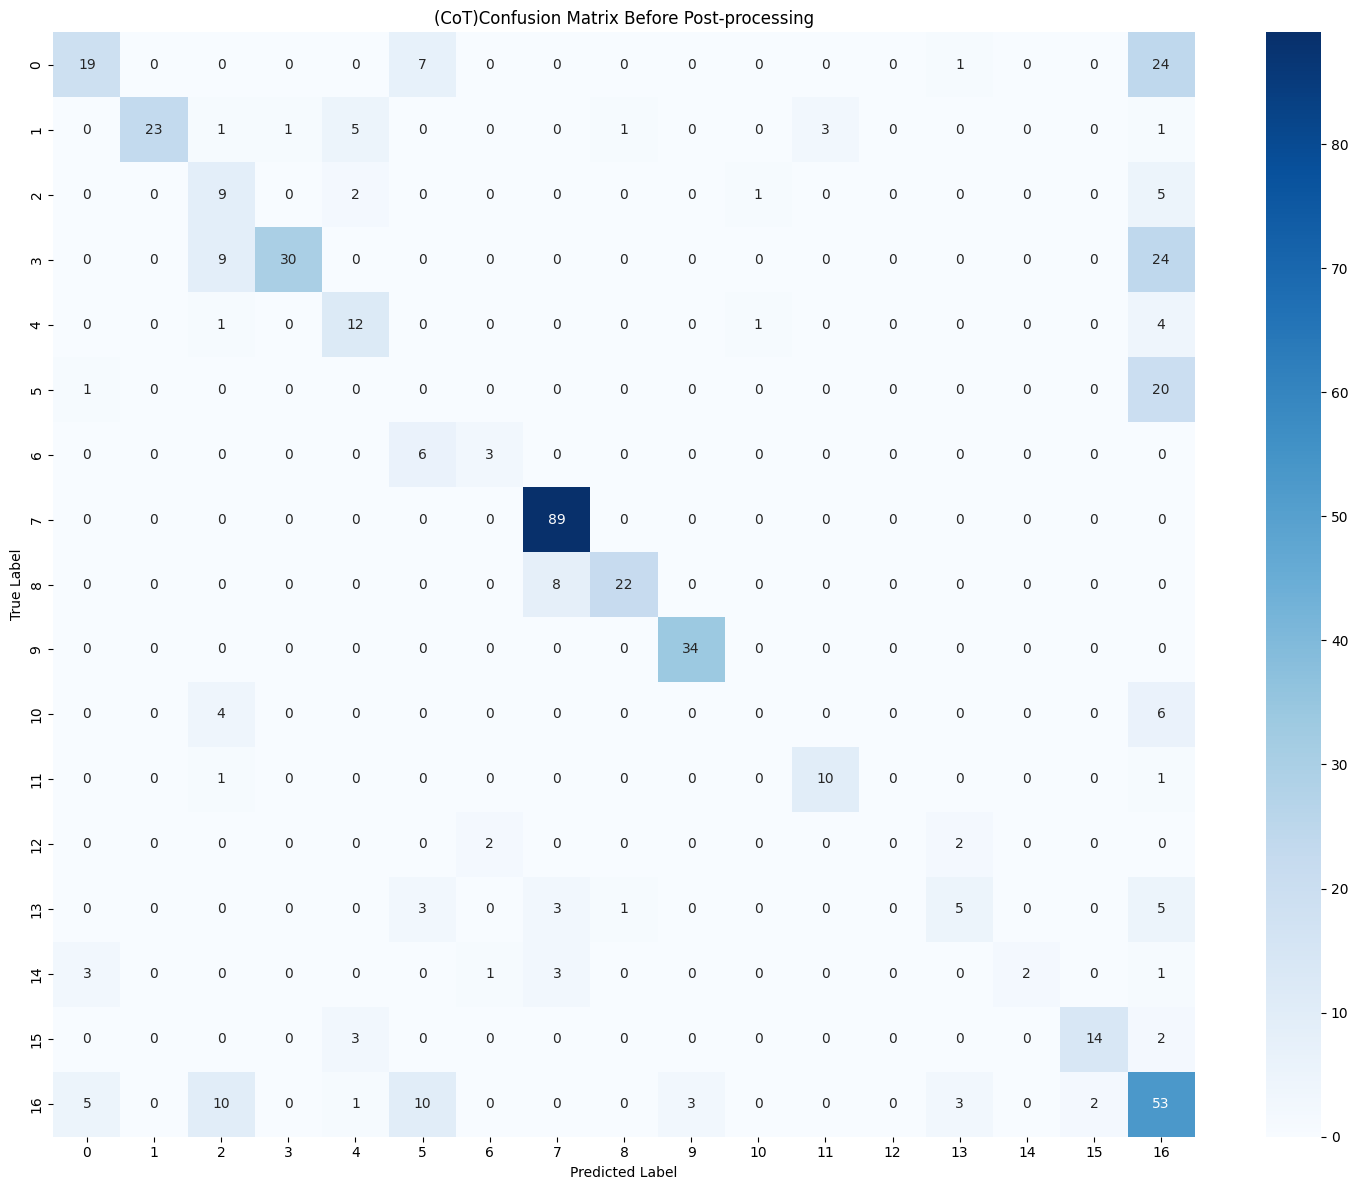

In [36]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 获取预测结果
y_pred = model_rf.predict(test_all_features)

# 打印分类报告
print("Classification Report:")
print(classification_report(test_all_labels, y_pred))

# 计算混淆矩阵
cm = confusion_matrix(test_all_labels, y_pred, labels=np.arange(17))  # 确保使用0-16的标签

# 创建更大的图表
plt.figure(figsize=(15, 12))  # 调整为更大的尺寸

# 绘制热力图
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.arange(17),  # 使用0-16的标签
            yticklabels=np.arange(17))

# 设置标题和标签
plt.title("(CoT)Confusion Matrix Before Post-processing")  # 增加标题和图表的间距
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# 调整布局
plt.tight_layout()

# 显示图表
plt.show()

In [37]:
def post_process_predictions(pred_labels, pred_probs, threshold=0.6):
    """
    根据后处理规则调整预测结果，考虑模型的预测概率。

    参数：
    - pred_labels: 模型的预测标签列表或数组。
    - pred_probs: 模型的预测概率数组，形状为 (样本数, 类别数)。
    - threshold: 置信度阈值，低于该值的预测将被考虑进行后处理。

    返回：
    - adjusted_preds: 经过调整的预测标签列表。
    """
    import numpy as np

    adjusted_preds = pred_labels.copy()
    adjusted_preds = np.array(adjusted_preds)
    pred_probs = np.array(pred_probs)

    # 获取预测序列的长度
    seq_len = len(adjusted_preds)

    # 获取模型预测的置信度（最大概率值）
    confidences = np.max(pred_probs, axis=1)

    # 规则 1：修正动作 6（Open the gastrostomy cap）
    for i in range(1, seq_len):
        if adjusted_preds[i] == 7 and confidences[i] < threshold:
            if adjusted_preds[i - 1] != 6:
                adjusted_preds[i - 1] = 6

    # 规则 2：修正动作 12（Close the clamp）
    for i in range(1, seq_len):
        if adjusted_preds[i] == 13 and confidences[i] < threshold:
            if adjusted_preds[i - 1] != 12:
                adjusted_preds[i - 1] = 12

    # 规则 3：修正动作 14（Close the gastrostomy cap）
    for i in range(1, seq_len - 1):
        if adjusted_preds[i] == 13 and adjusted_preds[i + 1] == 7 and confidences[i + 1] < threshold:
            if i + 2 < seq_len and adjusted_preds[i + 2] != 14:  # 添加边界检查
                adjusted_preds[i + 2] = 14

    # 规则 4：修正动作 10（Removal of gloves）
    for i in range(seq_len - 1):
        if adjusted_preds[i] == 15 and confidences[i] < threshold:
            if adjusted_preds[i + 1] != 10:
                adjusted_preds[i + 1] = 10

    return adjusted_preds.tolist()

# 获取模型预测概率和预测标签
pred_probs = model_rf.predict_proba(test_all_features)
y_predict = model_rf.predict(test_all_features)

# 应用后处理规则
adjusted_preds = post_process_predictions(y_predict, pred_probs, threshold=0.6)

# 打印处理前后的分类报告
from sklearn.metrics import classification_report

print("The result before：")
print(classification_report(test_all_labels, y_predict))

print("\nThe result after：")
print(classification_report(test_all_labels, adjusted_preds))

The result before：
              precision    recall  f1-score   support

           0       0.68      0.37      0.48        51
           1       1.00      0.66      0.79        35
           2       0.26      0.53      0.35        17
           3       0.97      0.48      0.64        63
           4       0.52      0.67      0.59        18
           5       0.00      0.00      0.00        21
           6       0.50      0.33      0.40         9
           7       0.86      1.00      0.93        89
           8       0.92      0.73      0.81        30
           9       0.92      1.00      0.96        34
          10       0.00      0.00      0.00        10
          11       0.77      0.83      0.80        12
          12       0.00      0.00      0.00         4
          13       0.45      0.29      0.36        17
          14       1.00      0.20      0.33        10
          15       0.88      0.74      0.80        19
          16       0.36      0.61      0.45        87

    acc

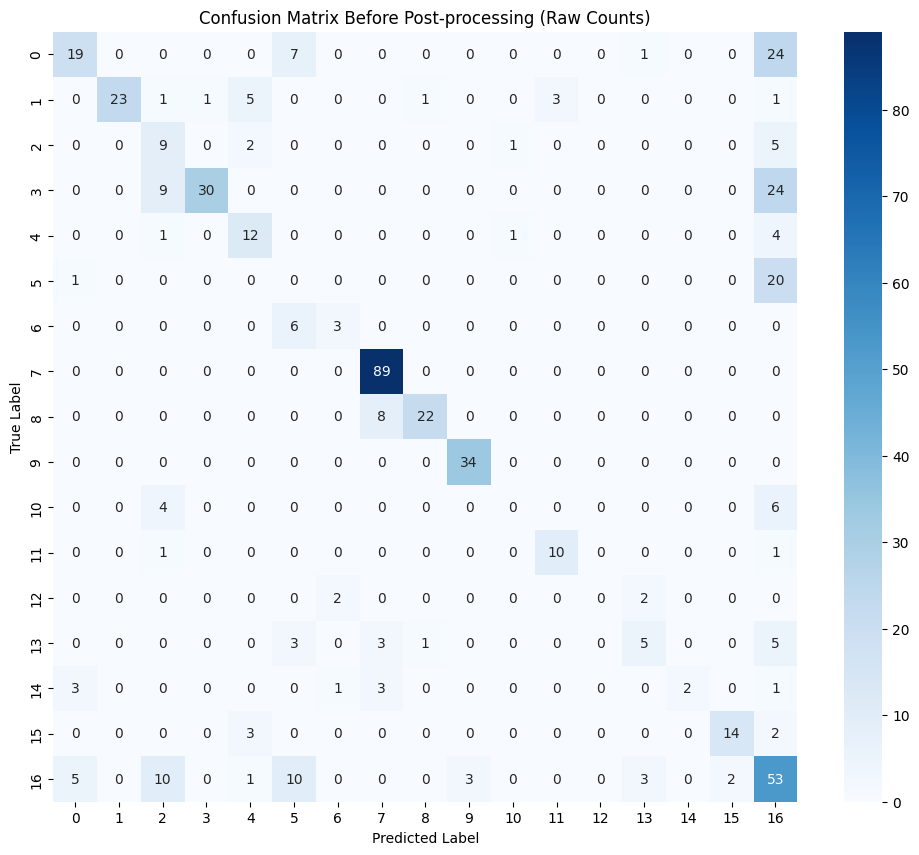

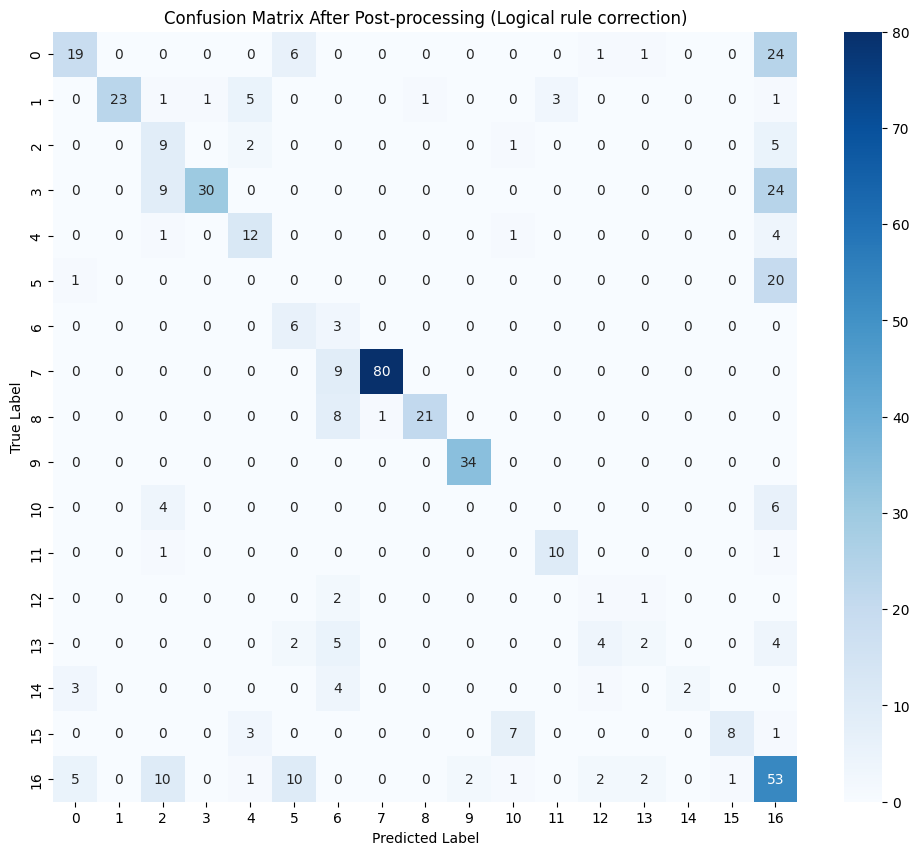

In [38]:
# 计算并显示混淆矩阵
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 处理前的混淆矩阵
cm_before = confusion_matrix(test_all_labels, y_predict)
plt.figure(figsize=(12, 10))
sns.heatmap(cm_before, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix Before Post-processing (Raw Counts)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# 处理后的混淆矩阵
cm_after = confusion_matrix(test_all_labels, adjusted_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm_after, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix After Post-processing (Logical rule correction)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [39]:
# 计算每个动作的平均持续时间
def calculate_avg_durations(ann_data, fs=FS):
    durations = {}
    for ann_df in ann_data:
        for _, row in ann_df.iterrows():
            action = row['activityID']
            duration = row['stop_time'] - row['start_time']
            if action not in durations:
                durations[action] = []
            durations[action].append(duration)

    avg_durations = {}
    for action, times in durations.items():
        avg_durations[action] = np.mean(times)

    return avg_durations

# 计算训练集的平均持续时间
train_avg_duration = calculate_avg_durations(all_ann_data)


===== Post-processing Analysis =====
Comparison of Actual and Predicted Labels:
    True Labels  Pred Labels
0            16           16
1             1            2
2             1            4
3             1            3
4             1            4
5             1            4
6             1            4
7             1            4
8            16            2
9            16            2
10            4           10
11            4            2
12           16            0
13           16            0
14           16            0
15           16           16
16            4           16
17            4           16
18            4           16
19            4            4

1. Dynamic Window Smoothing...

Dynamic Smoothing Results:
              precision    recall  f1-score   support

           0       0.64      0.35      0.46        51
           1       0.93      0.71      0.81        35
           2       0.15      0.24      0.18        17
           3       0.87      0.43

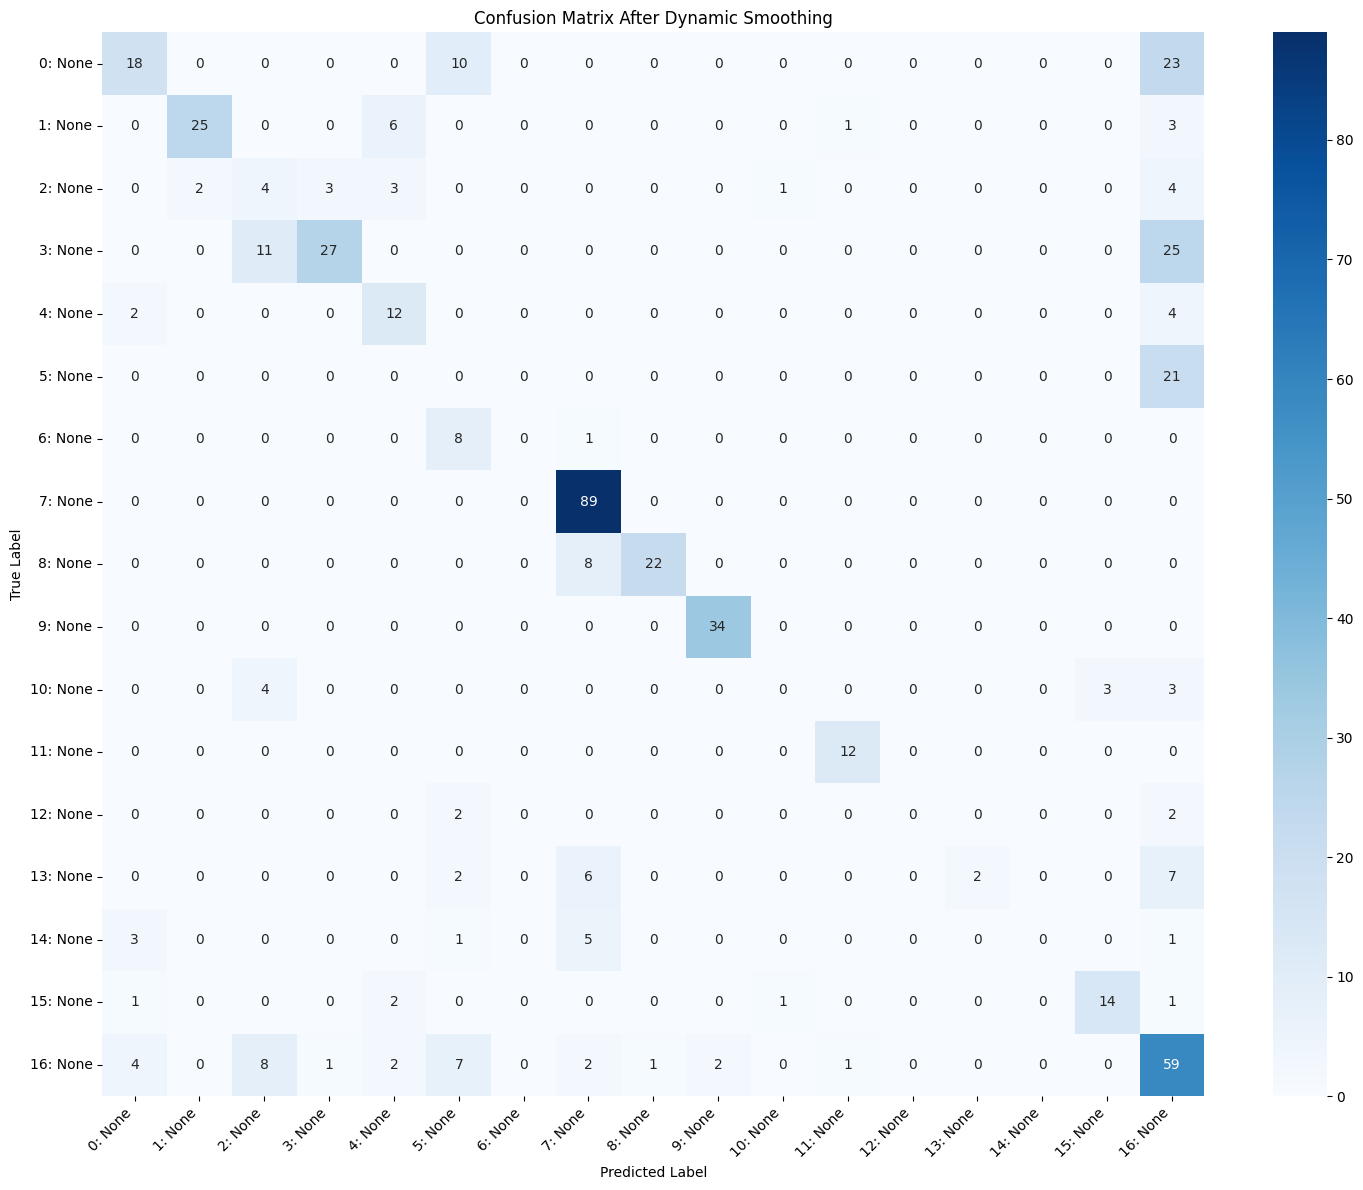


2. Short-Action Priority Smoothing...

Short-Action Priority Smoothing Results:
              precision    recall  f1-score   support

           0       0.69      0.35      0.47        51
           1       0.93      0.71      0.81        35
           2       0.15      0.24      0.18        17
           3       0.87      0.43      0.57        63
           4       0.48      0.67      0.56        18
           5       0.00      0.00      0.00        21
           6       0.00      0.00      0.00         9
           7       0.82      1.00      0.90        89
           8       0.96      0.73      0.83        30
           9       0.94      1.00      0.97        34
          10       0.00      0.00      0.00        10
          11       0.86      1.00      0.92        12
          12       0.00      0.00      0.00         4
          13       1.00      0.12      0.21        17
          14       1.00      0.20      0.33        10
          15       0.82      0.74      0.78        19


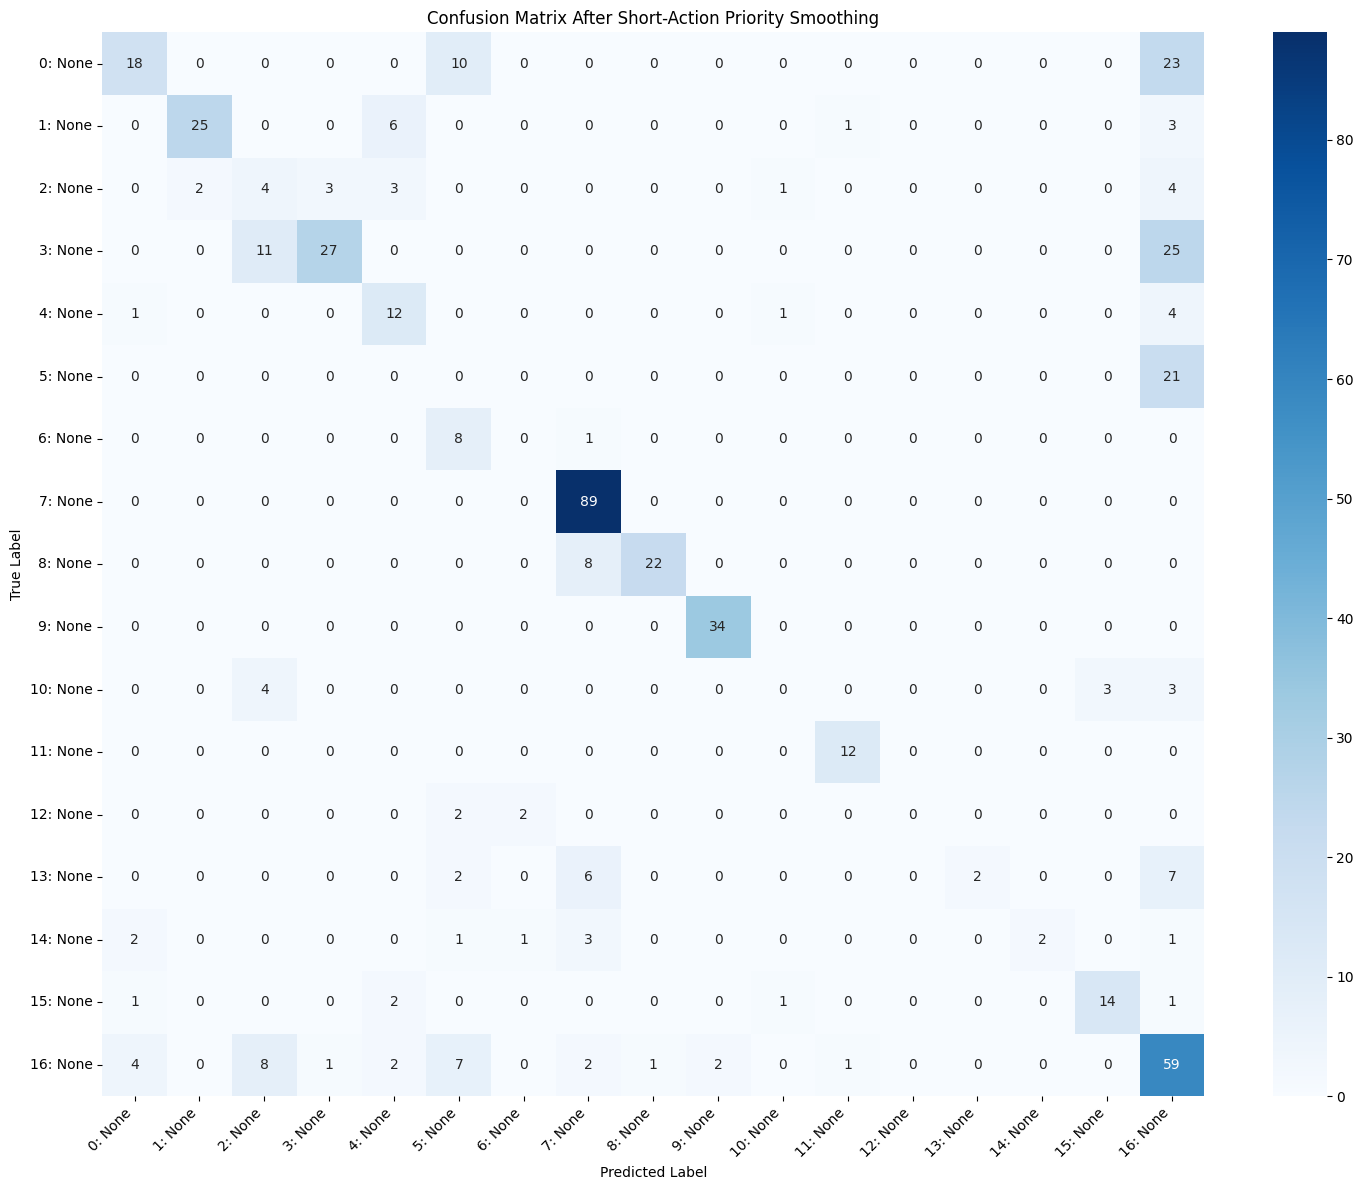

In [43]:
# =========【后处理：预测结果分析】=========
print("\n===== Post-processing Analysis =====")

# 保存预测结果
results_df = pd.DataFrame({
    "True Labels": test_all_labels,
    "Pred Labels": y_pred
})

print("Comparison of Actual and Predicted Labels:")
print(results_df.head(20))
results_df.to_csv("predictions_result.csv", index=False)

# =========【1. 动态窗口平滑】=========
print("\n1. Dynamic Window Smoothing...")

def dynamic_smooth_predictions(preds, avg_durations, fs, min_window=3, max_window=9):
    smoothed_preds = preds.copy()
    best_window_sizes = {}

    for action, avg_duration in avg_durations.items():
        window_size = max(min(int(avg_duration * fs), max_window), min_window)
        if window_size % 2 == 0:
            window_size += 1

        best_window_sizes[action] = window_size

        indices = np.where(preds == action)[0]
        if len(indices) > 0:
            padded_preds = np.pad(preds, (window_size // 2, window_size // 2), mode='edge')
            for i in indices:
                window = padded_preds[i:i + window_size]
                most_common = np.bincount(window).argmax()
                smoothed_preds[i] = most_common

    return smoothed_preds, best_window_sizes

# 应用动态平滑
dynamic_smoothed_preds, best_window_sizes = dynamic_smooth_predictions(
    y_pred, avg_durations=train_avg_duration, fs=FS
)

print("\nDynamic Smoothing Results:")
print(classification_report(test_all_labels, dynamic_smoothed_preds))
print("Accuracy after dynamic smoothing:", accuracy_score(test_all_labels, dynamic_smoothed_preds))

# 绘制动态平滑后的混淆矩阵
plt.figure(figsize=(15, 12))
cm_dynamic = confusion_matrix(test_all_labels, dynamic_smoothed_preds, labels=np.arange(17))
sns.heatmap(cm_dynamic, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f"{i}: {action_mapping.get(i)}" for i in range(17)],
            yticklabels=[f"{i}: {action_mapping.get(i)}" for i in range(17)])
plt.title("Confusion Matrix After Dynamic Smoothing")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# =========【2. 短时间动作优先平滑】=========
print("\n2. Short-Action Priority Smoothing...")

def smooth_predictions_short_priority(preds, window_size=9, short_actions=None, short_action_min_length=3):
    if short_actions is None:
        short_actions = []

    smoothed_preds = []
    half_window = window_size // 2
    padded_preds = np.pad(preds, (half_window, half_window), mode='edge')

    for i in range(len(preds)):
        window = padded_preds[i:i + window_size]
        most_common = np.bincount(window).argmax()

        if preds[i] in short_actions:
            count = 1
            # 向前检查
            for j in range(i - 1, max(-1, i - short_action_min_length), -1):
                if preds[j] != preds[i]:
                    break
                count += 1
            # 向后检查
            for j in range(i + 1, min(len(preds), i + short_action_min_length)):
                if preds[j] != preds[i]:
                    break
                count += 1

            if count < short_action_min_length:
                most_common = preds[i]

        smoothed_preds.append(most_common)

    return np.array(smoothed_preds)

# 应用短时间动作优先平滑
short_actions = [6, 10, 12, 14]  # 需要优化的短时间动作
smoothed_preds_short = smooth_predictions_short_priority(
    y_pred,
    window_size=9,
    short_actions=short_actions,
    short_action_min_length=3
)

print("\nShort-Action Priority Smoothing Results:")
print(classification_report(test_all_labels, smoothed_preds_short))
print("Accuracy after short-action priority smoothing:",
      accuracy_score(test_all_labels, smoothed_preds_short))

# 绘制短时间动作优先平滑后的混淆矩阵
plt.figure(figsize=(15, 12))
cm_short = confusion_matrix(test_all_labels, smoothed_preds_short, labels=np.arange(17))
sns.heatmap(cm_short, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f"{i}: {action_mapping.get(i)}" for i in range(17)],
            yticklabels=[f"{i}: {action_mapping.get(i)}" for i in range(17)])
plt.title("Confusion Matrix After Short-Action Priority Smoothing")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


=== Dynamic Window Smoothing Results ===


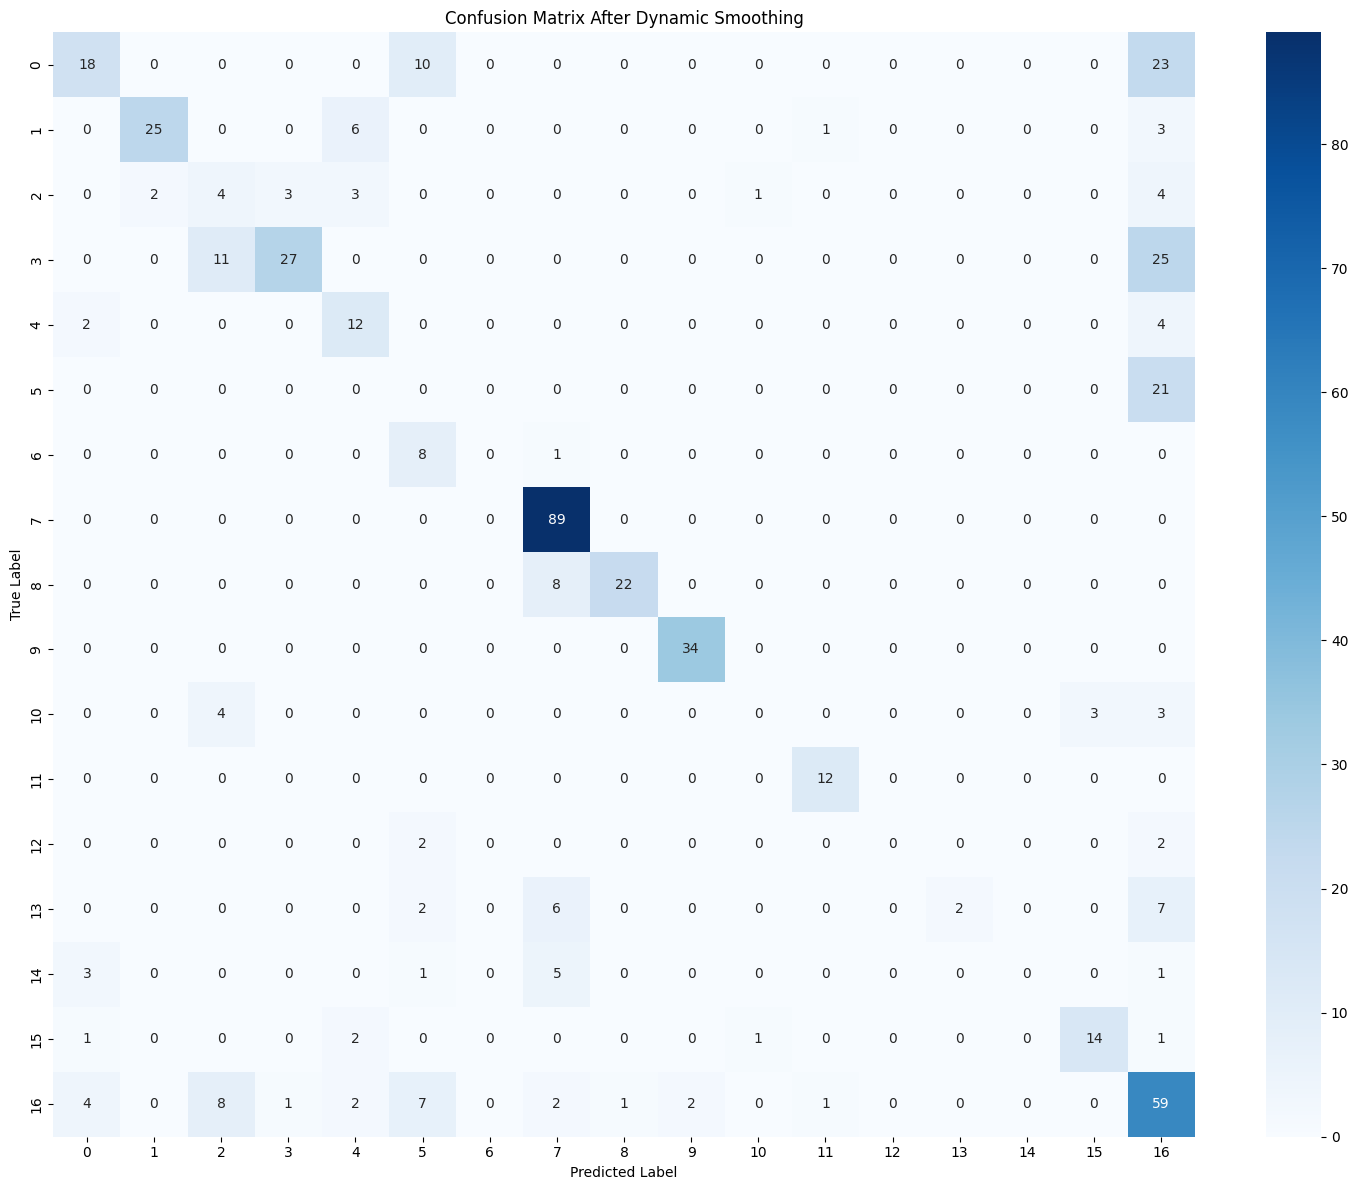


=== Short-Action Priority Smoothing Results ===


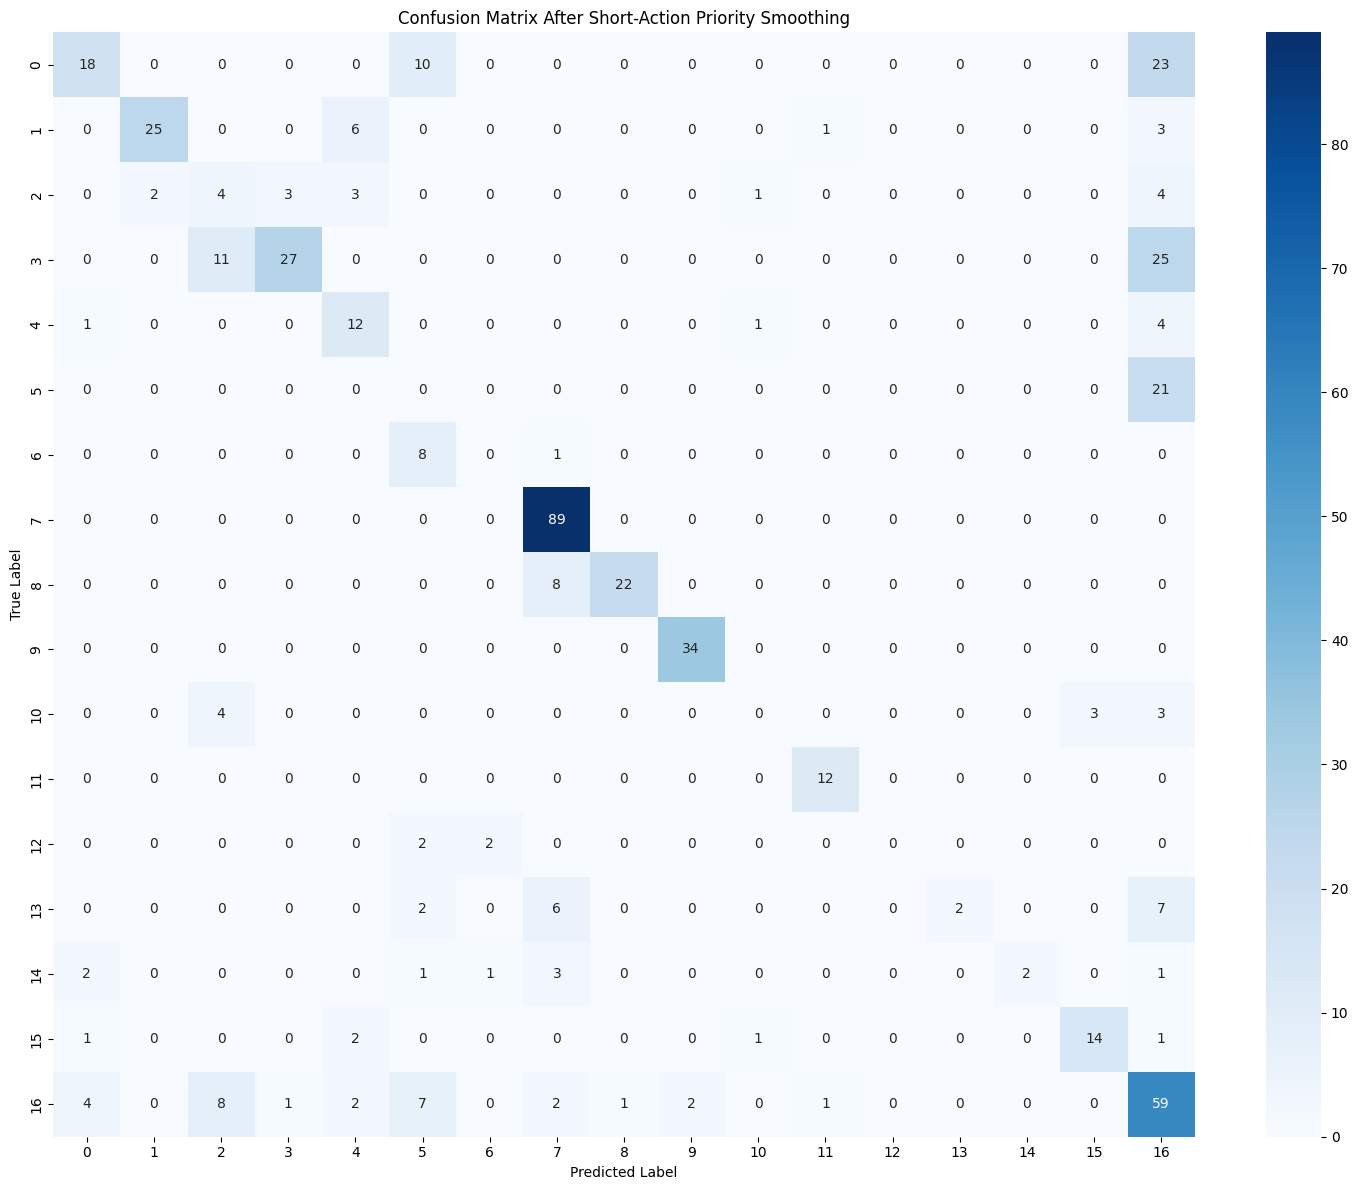

In [41]:
# =========【后处理：动态窗口平滑】=========
print("\n=== Dynamic Window Smoothing Results ===")

# 绘制动态平滑后的混淆矩阵
plt.figure(figsize=(15, 12))
cm_dynamic = confusion_matrix(test_all_labels, dynamic_smoothed_preds, labels=np.arange(17))
sns.heatmap(cm_dynamic, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.arange(17),  # 只显示数字标签
            yticklabels=np.arange(17))  # 只显示数字标签
plt.title("Confusion Matrix After Dynamic Smoothing")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# =========【后处理：短时间动作优先平滑】=========
print("\n=== Short-Action Priority Smoothing Results ===")

# 绘制短时间动作优先平滑后的混淆矩阵
plt.figure(figsize=(15, 12))
cm_short = confusion_matrix(test_all_labels, smoothed_preds_short, labels=np.arange(17))
sns.heatmap(cm_short, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.arange(17),  # 只显示数字标签
            yticklabels=np.arange(17))  # 只显示数字标签
plt.title("Confusion Matrix After Short-Action Priority Smoothing")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()